In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


In [2]:
# standard gpt modules + model definition

@dataclass
class Config:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.fc1 = nn.Linear(config.n_embd, config.n_embd * 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.n_embd * 4, config.n_embd)
    
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.proj = nn.Linear(config.n_embd, config.n_embd)

        self.attn_dropout = nn.Dropout(config.dropout)
        self.redidual_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
    
    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.attn(x).chunk(3, dim=2)
        q = q.view(B, T, self.n_head, self.n_embd // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.n_embd // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.n_embd // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (k.size(-1) ** (-1/2))
        att = att.masked_fill(self.tril[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        att = att @ v

        y = att.transpose(1, 2).contiguous().view(B, T, C)

        y = self.redidual_dropout(self.proj(y))
        return y
    
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

        self.sa = SelfAttention(config)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class Embed(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.te = nn.Embedding(config.vocab_size, config.n_embd)
        self.pe = nn.Embedding(config.block_size, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        T = x.size(1)
        pos = torch.arange(T, device=x.device).unsqueeze(0)
        return self.dropout(self.te(x) + self.pe(pos))

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed = Embed(config)

        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        print("params:", self.get_param_count())
    
    def get_param_count(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x, y=None):
        x = self.embed(x)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if y is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

        return logits, loss

In [3]:
1 - (torch.randn(1, 10) * 2 > 1).float()

tensor([[1., 1., 0., 1., 1., 0., 1., 1., 1., 1.]])

In [4]:
class Looper(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.L = nn.Parameter(torch.tensor(1.5))

        self.layer = layer
    
    def forward(self, x):
        lower = torch.floor(self.L)

        for _ in range(int(lower)):
            x = self.layer(x)
        
        x = x * (1 - (self.L - lower)) + self.layer(x) * (self.L - lower)
        
        return x

class MLP1Output(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.fc1 = nn.Linear(config.n_embd, config.n_embd * 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.n_embd * 2, 1)
    
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class LooperCalculator(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

        self.sa = SelfAttention(config)
        self.mlp = MLP1Output(config)
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x
    
class DynamicLooper(nn.Module):
    def __init__(self, config,  layer, max_NL=10):
        super().__init__()

        self.loop_calculator = Block(config)
        self.max_NL = max_NL

        self.layer = layer

        self.avg_loop = 0
    
    def forward(self, x):
        ls = F.sigmoid(self.loop_calculator(x)) * self.max_NL

        max_L = torch.max(ls).ceil()

        for i in range(int(max_L)):
            multipliers = (ls > i).float()

            x = (x * (1 - multipliers)) + self.layer(x) * multipliers
        
        fractional = ls - torch.floor(ls)

        x = x * (1 - fractional) + self.layer(x) * fractional

        self.avg_loop = 0.9 * self.avg_loop + 0.1 * ls.mean().item()

        return x


class GPTLooper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed = Embed(config)

        self.blocks = nn.ModuleList([Looper(Block(config)) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        print("params:", self.get_param_count())
    
    def get_param_count(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x, y=None):
        x = self.embed(x)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if y is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

        return logits, loss


class DynamicGPTLooper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed = Embed(config)

        self.blocks = nn.ModuleList([DynamicLooper(config, Block(config)) for _ in range(config.n_layer)])

        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        print("params:", self.get_param_count())
    
    def get_param_count(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x, y=None):
        x = self.embed(x)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if y is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

        return logits, loss


In [5]:
# the basic idea of the offramp is to have an LM head and accuracy predictor at every block
# if the accuracy predictor is good enough, we can stop the model early

class OffRamp(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.block = Block(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.acc_predictor = MLP1Output(config)

    def forward(self, x):
        x = self.block(x)
        logits = self.lm_head(x)
        acc = self.acc_predictor(x)
        return x, logits, acc

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
with open('input.txt', 'r') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i, ch in enumerate(chars) }
itos = { i:ch for i, ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

torch.manual_seed(1337)
data = torch.tensor(encode(text), dtype=torch.long, device=device)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [8]:
batch_size = 32

block_size = 128 
n_layer = 2
n_head = 8 
n_embd = 256

config = Config(block_size=block_size, vocab_size=vocab_size, n_layer=n_layer, n_head=n_head, n_embd=n_embd, dropout=0.1)
model = DynamicGPTLooper(config).to(device)

params: 3225600


In [9]:
def get_batch(split):
    data= train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(eval_iters=10):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:
def get_optimizer(model, base_lr=3e-4, l_lr=1e-3):
    l_params = [param for name, param in model.named_parameters() if 'layer' in name]
    other_params = [param for name, param in model.named_parameters() if 'layer' not in name]

    param_groups = [
        {'params': l_params, 'lr': l_lr},
        {'params': other_params, 'lr': base_lr}
    ]

    optimizer = torch.optim.Adam(param_groups)

    return optimizer

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = get_optimizer(model)

In [12]:
lossi = []
train_losses = []
test_losses = []

In [13]:
def iter():
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
    return loss

In [14]:
torch.autograd.set_detect_anomaly(True)

In [15]:
for i in range(10001):
    loss = iter()
    lossi.append(loss.item())
    if i % 100 == 0:
        print(f"iter: {i}, loss: {loss.item()}")
    if i % 1000 == 0:
        print()
        losses = estimate_loss()
        print(f"train loss: {losses['train']}, val loss: {losses['val']}")
        print()

        train_losses.append(losses['train'])
        test_losses.append(losses['val'])

        print("avg L values:")
        for layer in model.blocks:
            print(layer.avg_loop)

        # print("L values:")
        # for layer in model.blocks:
        #     print(layer.L.item())


iter: 0, loss: 4.4415788650512695

train loss: 3.7872462272644043, val loss: 3.8145980834960938

avg L values:
4.4341209209990495
4.027368718116302
iter: 100, loss: 2.548718214035034
iter: 200, loss: 2.4274096488952637
iter: 300, loss: 2.3076932430267334
iter: 400, loss: 2.1999266147613525
iter: 500, loss: 2.1222760677337646
iter: 600, loss: 2.012693166732788
iter: 700, loss: 1.8985097408294678
iter: 800, loss: 1.8966736793518066
iter: 900, loss: 1.851154088973999
iter: 1000, loss: 1.7216827869415283

train loss: 1.7363102436065674, val loss: 1.8778549432754517

avg L values:
6.5191471194091815
6.231697889165663
iter: 1100, loss: 1.7758798599243164
iter: 1200, loss: 1.7532345056533813
iter: 1300, loss: 1.7457566261291504
iter: 1400, loss: 1.6406198740005493
iter: 1500, loss: 1.5596801042556763
iter: 1600, loss: 1.615716814994812
iter: 1700, loss: 1.582979440689087
iter: 1800, loss: 1.6195865869522095
iter: 1900, loss: 1.5613229274749756
iter: 2000, loss: 1.5223931074142456

train loss:

In [16]:
def generate(max_new=256):
    model.eval()
    idx = torch.tensor(encode("\n"), dtype=torch.long, device=device).unsqueeze(0)
    print(idx)
    for _ in range(max_new):
        idx_cond = idx[:, -block_size:]
        logits, loss = model(idx_cond)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)

    # decode and print
    out = idx.squeeze().tolist()
    out = decode(out)

    model.train()
    return out

print(generate())

tensor([[0]], device='cuda:0')


HASTINGS:
We are thing withdraw to going; and in these joyfully
Did clip to his lady. A most command with
such fair death: if ever do not but I were curse shall be put a little
must be twixtued by these profits of it.
3 KING RICHARD II:
Fear, please your 


In [17]:
import matplotlib.pyplot as plt

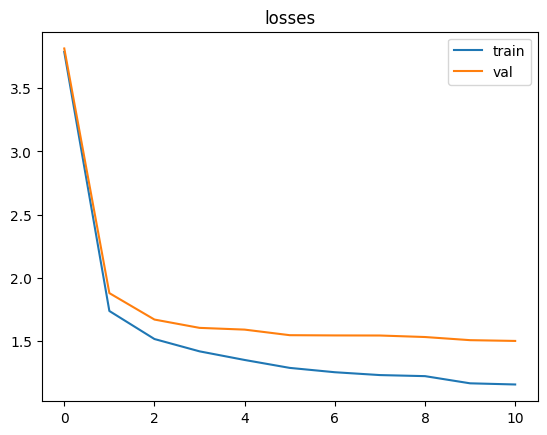

In [21]:
plt.title('losses')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='val')
plt.legend()
